# Prep

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#setup
import os, sys
current_path = os.path.abspath('')
parent_path = os.path.dirname(current_path)
source_path = f'{parent_path}\\src'
if not source_path in sys.path: sys.path.append(source_path)

#customs
# from data_model import *
# from data_helper import *
from config import *
setup()

Config finished!


<AxesSubplot:xlabel='Date'>

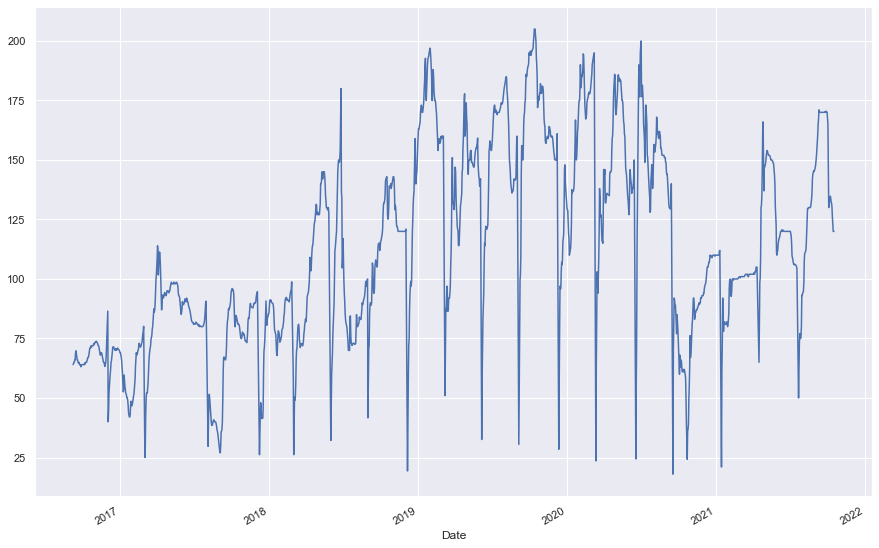

In [47]:
df = pd.read_csv('./data/Exalted Orb.csv', index_col='Date', parse_dates=True)
df['Value'].plot()

## Extra Features Engineering

In [48]:
df['LeagueDay'] = (df.groupby('League').cumcount() + 1).astype(np.float64)
df.head()

,Value,League,Confidence,LeagueDay
Date,,,,
2016-09-08,64.00417,Essence,0,1.0
2016-09-09,64.51451,Essence,0,2.0
2016-09-10,65.00280,Essence,0,3.0
2016-09-11,65.05764,Essence,0,4.0
2016-09-12,65.98811,Essence,0,5.0


# Helpers

In [101]:
def train_val_split(df, selected_features):
    is_last_league = df['League'] == Constants.LEAGUES[-1]

    df_selected = df[selected_features]
    df_train = df_selected[~is_last_league]
    df_val = df_selected[is_last_league]
    return df_train, df_val
def print_train_val_stats(train,val):
    print('shapes: ', train.shape, val.shape)
    display(train.head())
    display(val.head())

def getXY(df, target = 'Value'):
    df_features = df.drop(target, axis = 1)
    df_target = df.loc[:, [target]]
    return df_features, df_target


In [50]:
df_train, df_val = train_val_split(df, ['Value','LeagueDay'])
print_train_val_stats(df_train, df_val)

shapes:  (1719, 2) (88, 2)


,Value,LeagueDay
Date,,
2016-09-08,64.00417,1.0
2016-09-09,64.51451,2.0
2016-09-10,65.00280,3.0
2016-09-11,65.05764,4.0
2016-09-12,65.98811,5.0


,Value,LeagueDay
Date,,
2021-07-23,50.00000,1.0
2021-07-24,62.00000,2.0
2021-07-25,72.57994,3.0
2021-07-26,77.00000,4.0
2021-07-27,75.91450,5.0


# Trend extraction

In [53]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [54]:
trend_index_features = DeterministicProcess(
    index = df_train.index,
    order = 4,
    drop=True,
)
X_train_trend = trend_index_features.in_sample()
# X_train_trend = addFeatures(X_train_trend, df_train)
y_train_trend = df_train.loc[:,'Value']
display(X_train_trend.head())
display(y_train_trend.head())

,trend,trend_squared,trend_cubed,trend**4
Date,,,,
2016-09-08,1.0,1.0,1.0,1.0
2016-09-09,2.0,4.0,8.0,16.0
2016-09-10,3.0,9.0,27.0,81.0
2016-09-11,4.0,16.0,64.0,256.0
2016-09-12,5.0,25.0,125.0,625.0


Date
2016-09-08    64.00417
2016-09-09    64.51451
2016-09-10    65.00280
2016-09-11    65.05764
2016-09-12    65.98811
Name: Value, dtype: float64

In [55]:
from sklearn.linear_model import LinearRegression

trend_model = LinearRegression()
trend_model.fit(X_train_trend, y_train_trend)

pred_train_trend = pd.Series(trend_model.predict(X_train_trend), index=df_train.index)

X_val_trend = trend_index_features.out_of_sample(df_val.shape[0])
X_val_trend.index = df_val.index
y_val_trend = df_val.loc[:, 'Value']
pred_val_trend = pd.Series(trend_model.predict(X_val_trend), index= df_val.index)

F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\statsmodels\tsa\deterministic.py:157: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


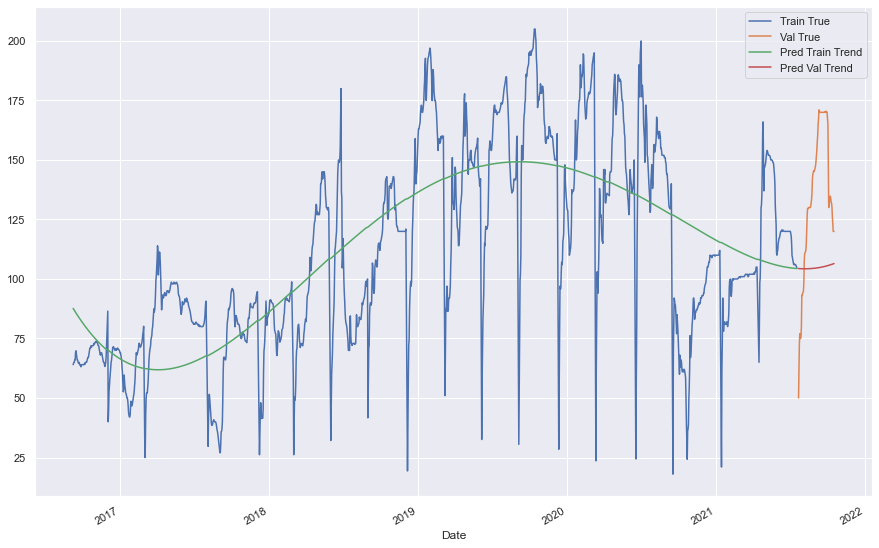

In [61]:
df_train['Value'].plot(label='Train True')
df_val['Value'].plot(label='Val True')
pred_train_trend.plot(label='Pred Train Trend')
pred_val_trend.plot(label='Pred Val Trend')
plt.legend()
plt.show()

### Residuals

<AxesSubplot:xlabel='Date'>

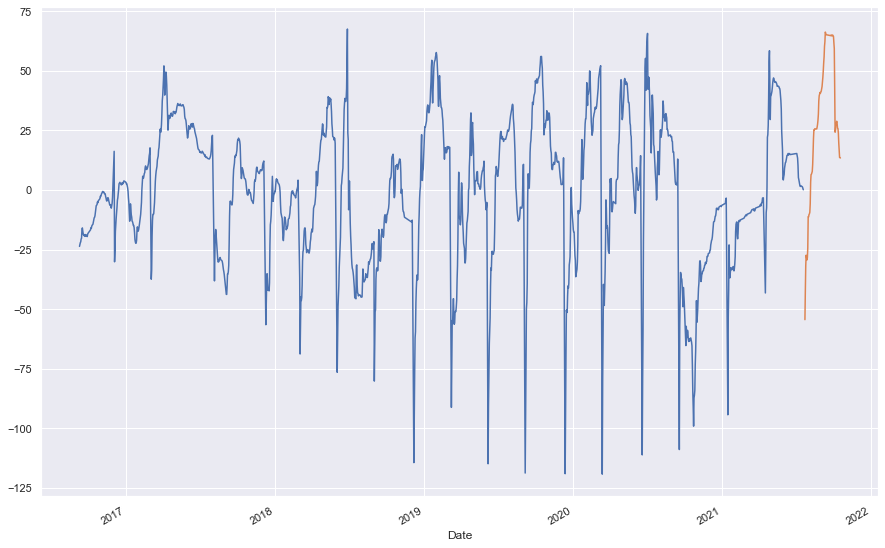

In [58]:
y_train_resid = y_train_trend - pred_train_trend
y_val_resid = y_val_trend - pred_val_trend

y_train_resid.plot()
y_val_resid.plot()

### NOTE:
It can be seen that the values are normalized to norm of around zero and i more even across the board after we remove the trend

# Learning the residuals

In [77]:
def addFeatures(trend_features, original_df, dropping=['Value']):
    return_df =  trend_features.merge(original_df, on='Date')
    return_df['lag1'] = return_df['Value'].shift(1)
    return return_df.drop(dropping, axis = 1).fillna(0)

In [78]:
resid_index_features = DeterministicProcess(
    index = df_train.index,
    order = 1,
    drop=True,
)
X_train_resid = resid_index_features.in_sample()
X_train_resid = addFeatures(X_train_resid, df_train)

F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\statsmodels\tsa\deterministic.py:157: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


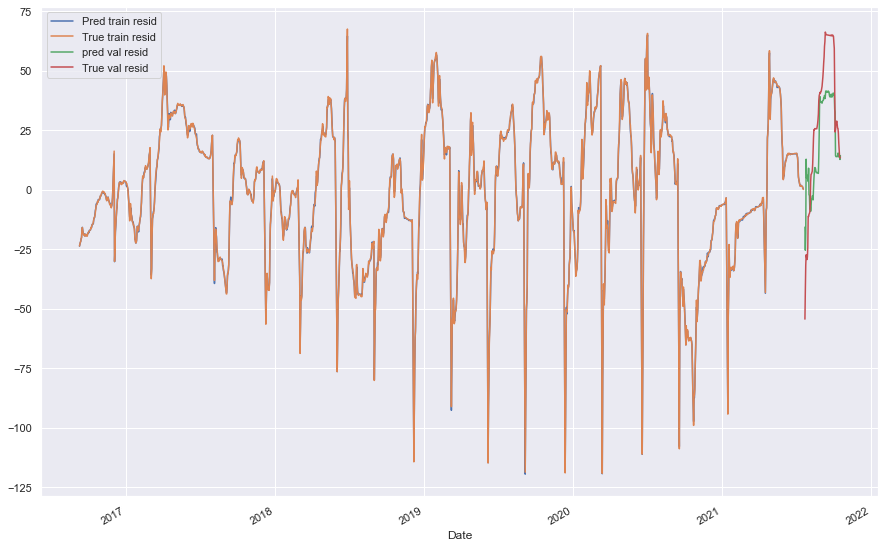

In [80]:
from xgboost import XGBRegressor
resid_model = XGBRegressor()
resid_model.fit(X_train_resid, y_train_resid)
pred_train_resid = pd.Series(resid_model.predict(X_train_resid), index=df_train.index)

X_val_resid = resid_index_features.out_of_sample(df_val.shape[0]).set_index(df_val.index)
X_val_resid = addFeatures(X_val_resid, df_val)

pred_val_resid = pd.Series(resid_model.predict(X_val_resid), index=df_val.index)


pred_train_resid.plot(label='Pred train resid')
y_train_resid.plot(label='True train resid')
pred_val_resid.plot(label='pred val resid')
y_val_resid.plot(label='True val resid')
plt.legend()
plt.show()

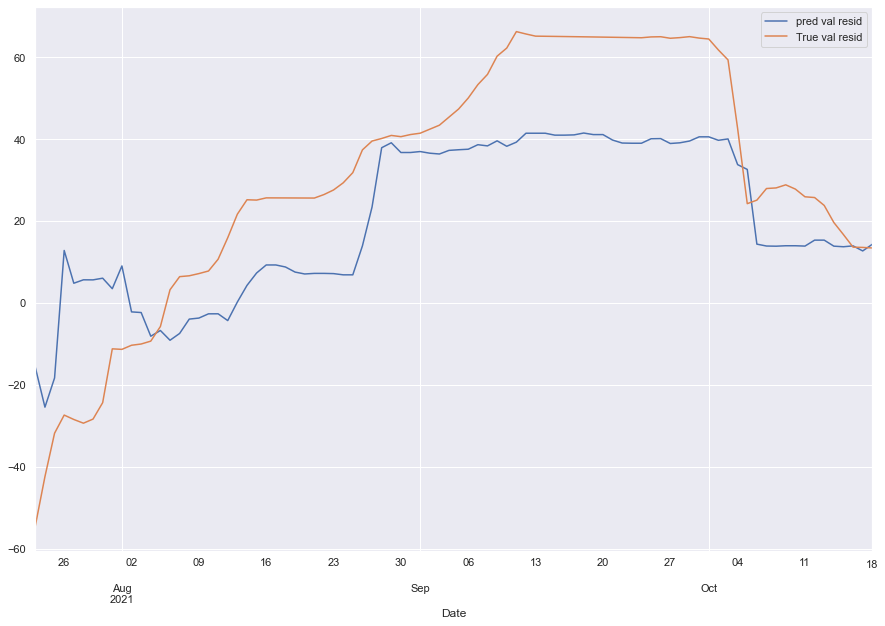

In [81]:
# zoomed
pred_val_resid.plot(label='pred val resid')
y_val_resid.plot(label='True val resid')
plt.legend()
plt.show()

# Hybrid Class

In [82]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
    
    def checkDataFrameInput(self, *df_inputs):
        last_df = df_inputs[-1]
        for i, df in enumerate(df_inputs[:-1]):
            if (last_df.index != df.index).any():
                raise Exception(f'Input dataframes must have same index ({i}, {len(df_inputs) - 1})')
    def fit(self, X_1, X_2, y):
        self.checkDataFrameInput(X_1, X_2, y)

        self.model_1.fit(X_1,y)
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )

        y_resid = y - y_fit

        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns

    def predict(self, X_1, X_2):
        self.checkDataFrameInput(X_1, X_2)

        y_pred_trend = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred_resid = pd.DataFrame(
            self.model_2.predict(X_2),
            index=X_2.index, columns=self.y_columns,
        )

        return y_pred_trend + y_pred_resid

In [83]:
model = BoostedHybrid(
    LinearRegression(),
    XGBRegressor(),
)

In [91]:
trend_index_features = DeterministicProcess(
    index = df_train.index,
    order = 4,
    drop=True,
)
X_train_trend = trend_index_features.in_sample().fillna(0)

y_train = df_train[['Value']]
# display(X_train_trend.head())
# display(y_train.head())

resid_index_features = DeterministicProcess(
    index = df_train.index,
    order = 1,
    drop=True,
)
X_train_resid = resid_index_features.in_sample()
X_train_resid = addFeatures(X_train_resid, df_train).fillna(0)

In [92]:
print(X_train_trend.shape, X_train_resid.shape, y_train.shape)

(1719, 4) (1719, 3) (1719, 1)


In [93]:
model.fit(X_train_trend, X_train_resid, y_train)
pred = model.predict(X_train_trend, X_train_resid)


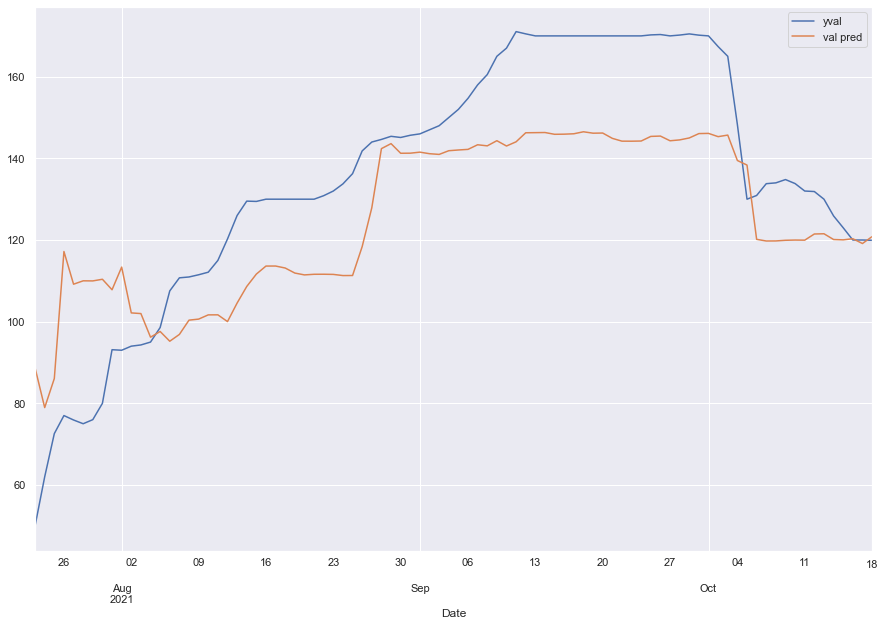

In [99]:
y_val['Value'].plot(label='yval')
pred_val['Value'].plot(label='val pred')
plt.legend()
plt.show()

In [96]:
# validation
X_val_trend = trend_index_features.out_of_sample(df_val.shape[0]).set_index(df_val.index).fillna(0)

y_val = df_val[['Value']]
X_val_resid = resid_index_features.out_of_sample(df_val.shape[0]).set_index(df_val.index)
X_val_resid = addFeatures(X_val_resid, df_val).fillna(0)

F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\statsmodels\tsa\deterministic.py:157: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\statsmodels\tsa\deterministic.py:157: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


In [97]:
pred_val = model.predict(X_val_trend, X_val_resid)

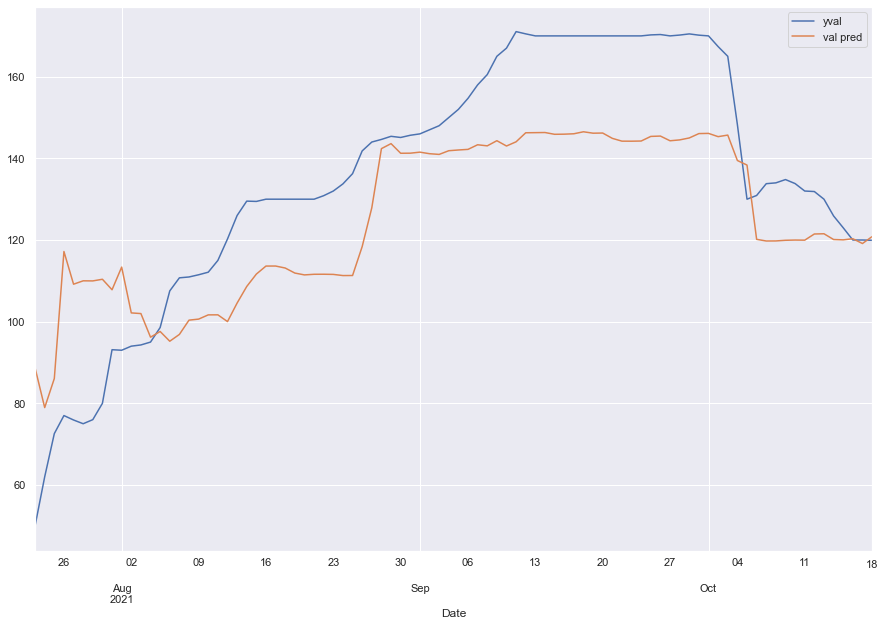

In [100]:
y_val['Value'].plot(label='yval')
pred_val['Value'].plot(label='val pred')
plt.legend()
plt.show()

# Eval

In [102]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
def evaluate(model, X1, X2 , y_val):
    pred = model.predict(X1, X2)
    mse = mean_squared_error(pred, y_val)
    mape = mean_absolute_percentage_error(pred, y_val)
    print('Result - MSE: ', mse, ' - MAPE: ', mape)


In [103]:
print('train')
evaluate(model, X_train_trend, X_train_resid, y_train)
print('val')
evaluate(model, X_val_trend, X_val_resid, y_val)

train
Result - MSE:  1.2546961892292001  - MAPE:  0.007263139488541257
val
Result - MSE:  374.0221389894474  - MAPE:  0.13877152702420956
